# Fresh Idea
## separate one/zero activity of domains
- replace zeros by minus one
- calculate the class activity for 3 hours bins for each domain
- calculate the user activity for gaussian around center of 3 hour bins
- calculate the likelihood of the person being a 1/-1 in that time 
- add user general metrics including domain cls activity and usage patterns

### questions
- how to take into account times when the person used a website when others didnt?
- how to give likelihood when the person didn't show any nearby activity?
- what if he used a similar website at same time but more nich? 
- how to average the bins weighted by the significance of that bin?
- how to give weight to the magnitude of number of users entering? probability of 1 with confidence
- what about sparse websites?
- how to not let times where there are no activity take a lot of weight?
### enhancements
- create graph embedding of urls
- for each bin, calculate the metric per url
- instead of only looking at the specific website, take into account websites with similar usages,
  for example looking at same domain_cls usage in gaussian around bin, or looking at domain embeddings and looking at the activity in similar embeddings weighted by the distance in the embedding space

### NOTICE:
the data itself will use all domains, even ones that the person never used. this could be an issue. 
first of all the fact that the person doesnt use them is an indication. we 
- we might want to take the niche websites and sum them up
- we might want to remove them

IDEA!
- use different features for different people
- make an ensemble that can differentiate between different users
- take the people that get a wrong prediction and see if a classifier that is more "fringe" can classify them better
- for example another tree classifier that takes a smaller amount of features to give more opportunity to fringe websites
can create a classifier for each user type 
can take number of usages for each domain, and cluster people or PCA
clustering is good - I can create a classifier for each cluster, from each cluster take all of the available data for all of the visited domains, and create a classifier for them. use only data from those users or all users that used one of the websites, plus the general model, for each cluster - use cluster model and general model.
also - I can multiply the features by the log of usages

another idea is to simply average the most prominent websites weighted by the specific user usages, and the general usage

USER CLUSTER AS FEATURE - or PCA coefficients

an idea - see how chaotic are the subject's patterns, if it's too predictable then it might be a bot


In [ ]:

import os
import ray
from modin.db_conn import ModinDatabaseConnection
from modin.config import NPartitions,RangePartitioning
os.environ["NEPTUNE_API_TOKEN"] = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMGMyZjIyZC0xMjQzLTQxNjQtYjZjZC0wMTRiZmJmZmRlZjYifQ=="
    # !export MODIN_CPUS=2
# n_cpus = 8
plasma_store_size = 130*(1024**3)
heap_memory = 230*(1024**3)
# os.environ["MODIN_CPUS"] = str(n_cpus)
# os.environ["MODIN_ENGINE"] = "ray"
os.environ["MODIN_NPARTITIONS"] = "30"
os.environ["MODIN_RANGE_PARTITIONING"] = "True"
# os.environ["MODIN_MEMORY"] = str(plasma_store_size)
ray.init(num_cpus =30,ignore_reinit_error=True, object_store_memory=plasma_store_size,_memory=heap_memory)
# print(ray.cluster_resources())
import modin.pandas as mpd
from modin import config as cfg
print(vars(cfg))
NEPTUNE_MODE="sync"


In [ ]:
# !export MODIN_CPUS=2
import neptune
import os

run = neptune.init_run(
    project="tom.touati/web-segmentation",  # replace with your project
    api_token=os.environ["NEPTUNE_API_TOKEN"],
    # name="Activity-Based Features",
    capture_stdout=True,
    capture_stderr=True,
    capture_hardware_metrics=True,
    tags=["time-based-models", "activity-based-features"],
    description="User activity patterns analysis",
    mode=NEPTUNE_MODE
)
import neptune

# Initialize Neptune run

# Log parameters
params = {}

    # "general_user_time_bin": {
    #     "should_run": True,
    #     "bin_hours": 3
    # },



run["parameters"] = params

# Log notebook
run["notebook"].upload("/home/tom.touati/mafat-challenge/code/time_based_model.ipynb")

# Log metrics


In [3]:
import os
import sqlite3
# %matplotlib widget
import matplotlib.pyplot as plt
from multiprocessing import freeze_support

%load_ext autoreload
%autoreload 2
  # Modin will use Ray
# ray.init()
# NPartitions.put(16)
def load_data_from_db(con,domain_cls=False,only_domain=False):
    try:
        # First get 1000 random Device_IDs
        # selective_device_ids_query = """
        # WITH random_devices AS (
        #     SELECT DISTINCT Device_ID 
        #     FROM data 
        #     LIMIT 1000
        # )
        # SELECT Domain_Name, Device_ID, Target,Datetime
        # FROM data 
        # WHERE Device_ID IN (SELECT Device_ID FROM random_devices)
        # AND Domain_Name != 1732927
        # """
        additional_query = ""
        if domain_cls:
            additional_query = ",Domain_cls1,Domain_cls2,Domain_cls3,Domain_cls4"
        device_ids_query = f"""SELECT Domain_Name, Device_ID, Target,Datetime{additional_query} from data"""
        
        if only_domain:
            device_ids_query = f"""SELECT Domain_Name{additional_query} from data"""
        # WHERE Domain_Name != 1732927 """
        df = mpd.read_sql(device_ids_query, con
                         )._repartition()
        df = df[df['Domain_Name'] != 1732927]
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        raise


# Add this line

In [ ]:
# load data from db
freeze_support()
dbfile = '../../data/training_set.db'

conn = ModinDatabaseConnection('sqlalchemy', f'sqlite:///{dbfile}')

# Can use get_connection to get underlying sqlalchemy engine
conn.get_connection()
db_df = load_data_from_db(conn)
print(db_df.head())
del conn  

In [5]:
db_df['Datetime'] = mpd.to_datetime(db_df['Datetime'])
db_df.set_index('Datetime', inplace=True)
db_df = db_df.astype( {'Domain_Name': 'uint32', 'Device_ID': 'uint32', 'Target': 'uint8'})

In [6]:
# prepare training data
import matplotlib.pyplot as plt
#train test split
from sklearn.model_selection import train_test_split
def get_train_test_devices(device_target_df, test_size=0.2, random_state=43):    
    # Perform stratified split on device IDs
    train_device_ids, test_device_ids = train_test_split(
        device_target_df['Device_ID'],
        test_size=test_size,
        random_state=random_state,
        stratify=device_target_df['Target']
    )
    return train_device_ids, test_device_ids

def get_initial_train_data(db_df, test_size=0.2, random_state=42, min_domain_devices=10,n_devices_hist=False):
    device_targets = db_df.groupby("Device_ID")["Target"].first().reset_index()
    train_devices, test_device_ids = get_train_test_devices(device_targets,test_size=test_size,random_state=random_state)
    train_df = db_df[db_df["Device_ID"].isin(train_devices)]
    devices_per_domain = train_df.groupby("Domain_Name")["Device_ID"].nunique()
    
    domain_mask = devices_per_domain>min_domain_devices
    print(f"Percentage of domains with more than {min_domain_devices} devices: {domain_mask.mean()*100:.2f}%")
    devices_per_domain = devices_per_domain[domain_mask]
    if n_devices_hist:
        hist = devices_per_domain.hist()
        run["plots/domain_devices_hist"].upload(neptune.types.File.as_image(hist.figure))
        plt.show()
    train_df = train_df[train_df["Domain_Name"].isin(devices_per_domain.index)]
    return train_df,train_devices,test_device_ids, device_targets, devices_per_domain


In [ ]:
params.update({"training_data":{
        "min_domain_devices": 10,
        "n_devices_hist":True,
        "test_size": 0.2,
        "random_state": 42
    }})
train_df,train_devices,test_device_ids, device_targets,devices_per_valid_domain = get_initial_train_data(db_df,**params["training_data"])


In [8]:
# %%writefile timeseries_processing.py
# preprocess timeseries
from functools import partial
def process_activity_timeseries(domain_df,bin_hours=6,gaussian_filter=True,n_days_each_side=3,std=1.5,drop_na=True,drop_zeros=False):
    activity_per_3h = domain_df[["Device_ID"]].resample(f'{str(bin_hours)}h').nunique()
    activity_per_3h.rename(columns={"Device_ID":"Activity"},inplace=True)
    # activity_per_3h = activity_per_3h.to_frame()

    gaussian_window_hours = int(n_days_each_side*24/bin_hours*2) # n_days_each_side * 24h / 3h_per_bin * 2 sides
    if gaussian_filter:
        activity_per_3h = activity_per_3h.rolling(window=gaussian_window_hours, win_type='gaussian',center=True,min_periods=1,closed="both").mean(std=std)
    if drop_na:
        activity_per_3h.dropna(inplace=True)
    if drop_zeros:
        activity_per_3h = activity_per_3h[activity_per_3h["Activity"]!=0]
    return activity_per_3h.round().astype(int)

def get_domain_activity_timeseries(train_df,domain_ts_kwargs):
    process_domain_timeseries = partial(process_activity_timeseries,**domain_ts_kwargs)
    process_domain_timeseries.__name__ =process_activity_timeseries.__name__
    domain_timeseries = train_df[["Domain_Name","Target","Device_ID"]].groupby(["Domain_Name","Target"]).apply(process_domain_timeseries)
    
    domain_timeseries = domain_timeseries
    domain_timeseries["activity_fraction"] = domain_timeseries.groupby(["Domain_Name", "Target"]).transform(lambda x: x/x.sum())
    # Add the sum of activity as a new column
    domain_activity = domain_timeseries.groupby(["Domain_Name", "Target"])[["Activity"]].sum()

    domain_activity = domain_activity.rename(columns={"Activity": "target_domain_activity"})
    # Merge the results
    domain_timeseries = domain_timeseries.merge(domain_activity, left_index=True, right_index=True)
    # Reset index to get Target as a column, then pivot to get Target as columns
    pivot_fraction_ts = domain_timeseries.reset_index().pivot(
        index=['Datetime', 'Domain_Name'],
        columns='Target'
    ).fillna(0)
    pivot_fraction_ts.columns = [f'{col[0]}_{col[1]}' for col in pivot_fraction_ts.columns]
    return pivot_fraction_ts
def get_user_activity_timeseries(db_df,user_ts_kwargs):
    process_user_timeseries = partial(process_activity_timeseries,**user_ts_kwargs)
    process_user_timeseries.__name__ =process_activity_timeseries.__name__
    user_timeseries = db_df[["Domain_Name","Device_ID"]].groupby(["Domain_Name","Device_ID"]).apply(process_user_timeseries)
    # user_timeseries.index = mpd.MultiIndex.from_tuples(user_timeseries.index.to_list(),names=["Domain_Name","Device_ID","Datetime"])
    return user_timeseries

In [ ]:
# train_df = train_df._repartition()
params.update({"domain_activity_timeseries": {
        "bin_hours": 6,
        "gaussian_filter": True, 
        "n_days_each_side": 7,
        "std": 1.5,
        "drop_na": False,
        "drop_zeros": True
    }})
domain_activity_timeseries = get_domain_activity_timeseries(
    train_df._repartition(), params["domain_activity_timeseries"])


In [10]:
# best_domain_activity = domain_activity_timeseries.reset_index("Datetime").loc[best_features].set_index("Datetime",append=True)

In [11]:

params.update({"user_activity_timeseries": {
        "bin_hours": 6,
        "gaussian_filter": True, 
        "n_days_each_side": 3,
        "std": 1.5,
        "drop_na": True,
        "drop_zeros": False
    }})
user_activity_timeseries = get_user_activity_timeseries(
    db_df.loc[db_df["Domain_Name"].isin(devices_per_valid_domain.index)], params["user_activity_timeseries"])


In [12]:
import gc
import ctypes
import sys

def cleanup_memory():
    """
    Force cleanup of memory by:
    1. Running garbage collection
    2. Attempting to release memory back to OS
    """
    # Force garbage collection
    gc.collect()
    
    # Attempt to release memory back to the OS
    if sys.platform.startswith('linux'):
        libc = ctypes.CDLL('libc.so.6')
        # MALLOC_TRIM(0) releases memory back to OS if possible
        libc.malloc_trim(0)

# Clean up memory
cleanup_memory()

In [13]:
# from scipy import stats
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import json
def class_probability_score(active, p_active_given_a, p_active_given_b, prior_a=0.5, total_users=100):
    """
    Calculate class probability score with vectorized operations
    
    Args:
        active: Boolean indicating if user was active
        p_active_given_a: Probability of activity given class A (0)
        p_active_given_b: Probability of activity given class B (1)
        prior_a: Prior probability for class A
        total_users: Total number of users for confidence calculation
    """
    # Use numpy for vectorized operations
    likelihood_a = np.where(active, p_active_given_a, 1 - p_active_given_a)
    likelihood_b = np.where(active, p_active_given_b, 1 - p_active_given_b)
    
    # Avoid division by zero
    evidence = (likelihood_a * prior_a + likelihood_b * (1 - prior_a))
    posterior_a = (likelihood_a * prior_a) / evidence

    return posterior_a #* confidence_factor

def get_user_domain_scores(domain_activity_timeseries,user_activity_timeseries):
    merged_timeseries_df = domain_activity_timeseries.reset_index().merge(
        user_activity_timeseries.reset_index(), how="left", on=["Domain_Name", "Datetime"]
    ).set_index(["Datetime", "Domain_Name", "Device_ID"])

    merged_timeseries_df["bin_activity"] = merged_timeseries_df["Activity_0"]+merged_timeseries_df["Activity_1"]
    merged_timeseries_df["total_activity"] = (merged_timeseries_df["target_domain_activity_0"]+merged_timeseries_df["target_domain_activity_1"])
    merged_timeseries_df["relative_0_activity"] = merged_timeseries_df["target_domain_activity_0"]/merged_timeseries_df["total_activity"]
    merged_timeseries_df["score"]=class_probability_score(merged_timeseries_df["Activity"], merged_timeseries_df["activity_fraction_0"], merged_timeseries_df["activity_fraction_1"], prior_a=merged_timeseries_df["relative_0_activity"], total_users=merged_timeseries_df["bin_activity"])
    merged_timeseries_df["relative_bin_activity"] = merged_timeseries_df["bin_activity"]/merged_timeseries_df["total_activity"]
    merged_timeseries_df["weighted_score"] = (merged_timeseries_df["score"])*(merged_timeseries_df["relative_bin_activity"])#np.log(1+merged_df["bin_activity"]).astype(int))
    
    #check (weighted_score-0.5)/std(weighted_score)/sqrt(total_activity)
    final_scores = merged_timeseries_df.groupby(["Device_ID","Domain_Name"])["weighted_score"].sum()
    
    final_scores_pivot = final_scores.to_frame().reset_index().pivot(index="Device_ID",columns="Domain_Name")
    return final_scores_pivot
def get_domain_usage_proportion(db_df):
    return db_df.groupby("Device_ID")["Domain_Name"].value_counts(normalize=True).unstack(fill_value=0).astype(np.float32)
    
def min_max_scale_all_values(df,train_devices,per_column=False):
    # Create MinMaxScaler and fit on training data
    scaler = MinMaxScaler(feature_range=(-1,1))
    train_data = df.loc[train_devices]
    scaler.fit(train_data if per_column else train_data.values.reshape(-1,1))

    # Transform all data using fitted scaler
    df.iloc[:,:] = scaler.transform(df if per_column else df.values.reshape(-1,1)).reshape(df.shape)

    # Save scaler parameters as JSON
    scaler_params = {
        "min_": float(scaler.min_[0]),  # Convert to native Python float
        "scale_": float(scaler.scale_[0]),
        "data_min_": float(scaler.data_min_[0]),
        "data_max_": float(scaler.data_max_[0]),
        "data_range_": float(scaler.data_range_[0]),
        "feature_range": list(scaler.feature_range)  # Convert tuple to list for JSON
    }
    return scaler_params
    # with open('submission/minmax_scaler.json', 'w') as f:
    #     json.dump(scaler_params, f)

In [ ]:
domain_usage_proportion = get_domain_usage_proportion(db_df)
domain_usage_proportion = ((domain_usage_proportion.T)/domain_usage_proportion.T.max()).T

In [ ]:

final_scores_pivot=get_user_domain_scores(domain_activity_timeseries,user_activity_timeseries)

In [54]:
# min_max_scale_all_values(final_scores_pivot,train_devices,per_column=False)

In [55]:
final_scores_pivot.fillna(0,inplace=True)

In [ ]:
final_scores_pivot.isna().sum().sum()   

In [126]:
final_scores_pivot = (final_scores_pivot-final_scores_pivot.stack().mean())/final_scores_pivot.stack().std()

In [ ]:
plt.figure()
final_scores_pivot.stack().hist()
plt.show()

In [130]:
target_features = device_targets.set_index("Device_ID").join(weighted_final_scores)


In [83]:
%matplotlib widget

In [109]:
min_max_scale_all_values(weighted_final_scores,train_devices,per_column=False)

In [ ]:
plt.figure()
weighted_final_scores = ((weighted_final_scores-weighted_final_scores.stack().mean())/weighted_final_scores.stack().std())
plt.show()

In [ ]:
plt.figure()
target_features.set_index("Target")[[int(x) for x in best_features if x.isnumeric()]].stack().groupby("Target").mean().plot(kind="bar")
plt.legend()
plt.show()

In [120]:
weighted_final_scores.fillna(0,inplace=True)

In [ ]:
(domain_usage_proportion==1).any()

In [ ]:
((domain_usage_proportion.T)/domain_usage_proportion.T.max()).T

In [ ]:
domain_usage_proportion.stack().hist(bins=20)

In [93]:
final_scores_pivot = (final_scores_pivot-final_scores_pivot.mean().mean())/final_scores_pivot.stack().std()

In [128]:
weighted_final_scores = final_scores_pivot.mul(domain_usage_proportion[final_scores_pivot.columns]).fillna(0)

In [46]:
targeted_weights = device_targets.set_index("Device_ID").join(weighted_final_scores)
targeted_weights=targeted_weights.melt(id_vars="Target",var_name="Domain_Name",value_name="Weight")

In [ ]:
# for target, g in targeted_weights.groupby("Target"):
#     plt.figure(figsize=(12, 6))
#     g = g.sort_values("Weight")
#     mean = g.mean()
#     perc_25 = g.quantile(0.25)
#     perc_75 = g.quantile(0.75)

#     plt.scatter(target, mean, label=f'Target {target}')
#     plt.fill_between(target, perc_25, perc_75, alpha=0.2)
    
# plt.legend()
# plt.show()

In [ ]:
weighted_final_scores.stack().describe()

In [ ]:
weighted_final_scores.stack().hist(bins=50)

In [ ]:
domain_usage_proportion[final_scores_pivot.columns].shape

In [ ]:
from sklearn.impute import KNNImputer# , IterativeImputer
from sklearn.linear_model import BayesianRidge
from scipy.sparse import csr_matrix
from implicit.cpu.als import AlternatingLeastSquares
def impute_missing_values(final_scores_pivot,train_device_ids):
    # Use SoftImpute to fill missing values
    imputer = KNNImputer(n_neighbors=10)
    imputer.fit(final_scores_pivot.loc[train_device_ids])
    imputed_scores = imputer.transform(final_scores_pivot)
    # imputer = AlternatingLeastSquares(factors=10, regularization=0.01, iterations=10,random_state=0)
    # # imputer = MissForest(max_depth=6,max_features=0.8, random_state=0)
    # imputer.fit( user_items = csr_matrix(final_scores_pivot.loc[train_device_ids].values))
    
    # imputed_scores = imputer.recommend_all(csr_matrix(final_scores_pivot.values))
    return imputed_scores

In [29]:
# min_max_scale_all_values(final_scores_pivot,train_devices,per_column=False)

In [30]:
from sklearn.decomposition import PCA

# baseline features
def get_active_days_per_user(user_domain_ts):
    """
    Calculate the number of unique days each user had any activity.

    Args:
        user_domain_ts: MultiIndex Series with levels [Domain_Name, Device_ID, Datetime]

    Returns:
        Series with index Device_ID and values being number of unique active days
    """
    # Reset index to get Datetime as a column
    df = user_domain_ts.reset_index()

    # Convert Datetime to date (removing time component)
    df['Date'] = df['Datetime'].dt.date

    # Group by Device_ID and count unique dates where Activity > 0
    active_days = df[df['Activity'] > 0].groupby('Device_ID')['Date'].nunique()

    active_days = active_days.astype(int)
    active_days.name = "Active_Days"
    active_days = (active_days-active_days.min()
                   ) / (active_days.max()-active_days.min())*2-1
    return active_days


def get_activity_per_time_bin(df, bin_hours=3):
    # Convert datetime to time only
    # time_index = db_df.index.to_series().dt.time
    # df["time"] = time_index
    df_copy = df.copy()
    df_copy["time"] = db_df.index.to_series().dt.hour.astype(int)//bin_hours
    df_copy["day_part_activity"] = 0
    activity_per_time_range = df_copy[["Device_ID", "time", "day_part_activity"]].groupby(
        ["Device_ID", "time"]).count()
    activity_per_time_range["activity_fraction"] = activity_per_time_range.groupby("Device_ID").apply(lambda x: x/x.sum()).values
    activity_per_time_range = activity_per_time_range[["activity_fraction"]].reset_index()
    activity_per_time_range = activity_per_time_range.pivot(index="Device_ID",columns="time",values="activity_fraction")
    activity_per_time_range.columns = [f"time_{col}" for col in activity_per_time_range.columns]
    activity_per_time_range = (activity_per_time_range-activity_per_time_range.stack().min())/(activity_per_time_range.stack().max()-activity_per_time_range.stack().min())*2-1
    activity_per_time_range = activity_per_time_range.fillna(0)
    return activity_per_time_range  # .round().astype(int)
def get_device_domain_pca(user_activity_timeseries, n_components=100):
    # Calculate total entries per domain for each device
    domain_entries = user_activity_timeseries.reset_index()[['Device_ID', 'Domain_Name','Activity']].groupby(['Device_ID', 'Domain_Name'])['Activity'].sum()
    domain_entries_pivot = domain_entries.unstack(fill_value=0)
    # domain_entries_pivot = domain_entries_pivot/domain_entries_pivot.sum(axis=1)
    # Normalize the data
    # normalized_data = (domain_entries_pivot - domain_entries_pivot.min().min()) / (domain_entries_pivot.max().max() - domain_entries_pivot.min().min())
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(domain_entries_pivot.fillna(0))
    # Print explained variance ratio
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance ratio: {explained_variance.sum():.3f}")
    # Create DataFrame with PCA results
    pca_df = mpd.DataFrame(
        pca_result,
        index=domain_entries_pivot.index,
        columns=[f'pca_domain_{i}' for i in range(n_components)]
    )
    
    return pca_df

In [ ]:
# load data from db

def get_cls_proportion(df):
    cols = ["Domain_cls1","Domain_cls2","Domain_cls3","Domain_cls4"]
    df = df.groupby("Device_ID")[cols].apply(lambda x: df.stack().value_counts(normalize=True).T.fillna(0).to_frame().T)

    
    df.columns = [f"cls_{col}" for col in df.columns]
    df.rename({"cls_Device_ID":"Device_ID"},axis=1,inplace=True)
    df.index = df.index.droplevel(-1)
    return df
def get_cls_data():
    """
    Feature engeinering: For each Device_ID calculate the proportions of all the domain_cls he entered.

    Parameters
    ----------
    conn: connection
        A connection object to the database.
    device_list : list
        A list of Device_IDs to calculate their proportions.

    Returns
    -------
    dataframe
        A dataframe with the proportions for each Device_IDs and Domain_cls.
    """
    freeze_support()
    dbfile = '../../data/training_set.db'

    conn = ModinDatabaseConnection('sqlalchemy', f'sqlite:///{dbfile}')

    # Can use get_connection to get underlying sqlalchemy engine
    conn.get_connection()
    sql = '''SELECT
                    Device_ID,
                    Domain_Name,
                    Domain_cls1,
                    Domain_cls2,
                    Domain_cls3,
                    Domain_cls4
                    from data
                    where Domain_Name != 1732927 and Domain_cls1 != 0 and Domain_cls2 != 0 and Domain_cls3 != 0 and Domain_cls4 != 0
                    '''

    df = mpd.read_sql(sql,conn, columns = ['Device_ID','Domain_cls', 'proportion'])
    
    return df
cls_data = get_cls_data()
cls_proportion = get_cls_proportion(cls_data)
del cls_data

In [33]:
# domain_best_features = [int(x) for x in best_features if x.isnumeric()]
# final_scores_pivot.loc[:,domain_best_features] = impute_missing_values(final_scores_pivot.loc[:,domain_best_features],train_devices)

In [170]:
final_features = device_targets.set_index("Device_ID").join(weighted_final_scores)
final_features = final_features.join(cls_proportion,how="left")
final_features = final_features.join(psd_df,how="left")
# final_features = final_features.join(device_domain_PCA,how="left")
# if active_days is not None:
#     final_features = final_features.join(active_days,how="left")
# if activity_per_time_range is not None:
#     final_features = final_features.join(activity_per_time_range,how="left")
# final_features = final_features.fillna(0)
# final_features.columns = [str(col) for col in final_features.columns]

In [169]:
from sklearn.preprocessing import StandardScaler

# Get power spectra for training devices only
train_psd = psd_df.loc[train_devices]

# Create and fit scaler on training data
scaler = StandardScaler()
scaler.fit(train_psd)

# Transform all data using fitted scaler
psd_df.iloc[:,:] = scaler.transform(psd_df)

In [171]:
psd_df

,0.000001,0.000002,0.000003,0.000004,0.000006,0.000007,0.000008,0.000009,0.000010,0.000011,...,0.000035,0.000036,0.000037,0.000039,0.000040,0.000041,0.000042,0.000043,0.000044,0.000045
Device_ID,,,,,,,,,,,,,,,,,,,,,
15,-0.054074,0.457498,-0.214107,2.356937,1.262161,-0.051471,1.228473,0.158336,0.333089,-0.575271,...,1.998243,-0.612611,3.380081,-0.416696,2.951713,2.525334,-0.612983,-0.037510,-0.696649,0.246628
27,-0.420540,0.354949,-0.258943,-0.244958,-0.530747,-0.219083,-0.288244,-0.226085,-0.461752,-0.585285,...,-0.574338,-0.531490,-0.354492,-0.576272,-0.484370,-0.543088,-0.725651,-0.495699,-0.605038,-0.470977
29,-0.417545,-0.465617,-0.309606,-0.199520,-0.429292,0.169986,-0.588737,-0.529289,-0.152972,0.519700,...,-0.573462,-0.089658,0.555333,-0.462649,-0.461036,0.956129,-0.472491,-0.478663,0.906515,0.439271
32,-0.419049,-0.407034,-0.304739,-0.543963,-0.547936,-0.521376,-0.554052,-0.521251,-0.271311,-0.544348,...,-0.751216,-0.700289,-0.710053,-0.701922,-0.736603,-0.675737,-0.572872,-0.526740,-0.571999,-0.617480
46,-0.146093,0.083301,0.293324,-0.386530,0.979801,-0.403740,-0.568381,-0.533975,-0.420433,-0.473298,...,-0.608332,-0.567780,-0.422021,-0.669198,-0.387102,0.593412,-0.165295,-0.346034,-0.324538,0.154793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69941,-0.369129,-0.143942,-0.424264,-0.456483,-0.265664,-0.328995,-0.077393,-0.347858,0.289322,-0.436038,...,0.525252,0.825924,0.624195,-0.362144,1.916502,1.009963,0.259751,2.880992,0.503888,0.453003
69944,0.637145,4.588586,1.683852,6.386305,5.348424,2.028525,2.351099,2.896505,0.481375,1.272232,...,0.199185,-0.081502,-0.712738,-0.104222,-0.585148,0.189063,0.572915,-0.481287,-0.431232,0.158507
69952,1.218508,1.427990,-0.252805,0.668361,0.285014,0.281073,0.526894,1.434425,2.763785,0.271638,...,2.570069,-0.411093,-0.366892,2.758861,3.431843,9.297580,-0.523783,1.446485,1.562530,2.281590


In [172]:
import xgboost
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
def prepare_model_data(final_features,train_devices,test_device_ids):
    X_train = final_features[final_features.index.isin(train_devices)].drop('Target', axis=1)
    y_train = final_features[final_features.index.isin(train_devices)]['Target']

    X_test = final_features[final_features.index.isin(test_device_ids)].drop('Target', axis=1)
    y_test = final_features[final_features.index.isin(test_device_ids)]['Target']
    return X_train,y_train,X_test,y_test

def train_model(X_train,y_train,X_test=None,y_test=None,params = None):
    xgb_reg = xgboost.XGBRegressor(**params ,eval_metric =roc_auc_score)
    selector = RFE(xgb_reg, n_features_to_select=1000, step=20000)
    selector = selector.fit(X_train, y_train)
    best_features = list(X_train.columns[selector.support_])
    if X_test is not None:
        test_prediction = selector.estimator_.predict(X_test[best_features])
        test_auc =round(roc_auc_score(y_test,test_prediction), 3)
        return test_auc,selector, best_features,y_test,test_prediction
    return None,selector, best_features, None,None
    

In [177]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import neptune

params.update({
    "feature_selection": {
        "n_features": 1000,
        "step": 20000
    },
    "model": dict(random_state=0, subsample=0.8, colsample_bytree=0.6, learning_rate= 0.1,
                               n_estimators= 250, max_depth=6, objective ='binary:logistic',reg_lambda = 1.3 ),
    "no-normalization-finalscores":True})

run = neptune.init_run(
    project="tom.touati/web-segmentation",  # replace with your project
    api_token=os.environ["NEPTUNE_API_TOKEN"],
    # name="Activity-Based Features",
    capture_stdout=True,
    capture_stderr=True,
    capture_hardware_metrics=True,
    tags=["time-based-models", "activity-based-features"],
    description="User activity patterns analysis",
    mode=NEPTUNE_MODE
)
run["parameters"] = params
run["notebook"].upload("/home/tom.touati/mafat-challenge/code/time_based_model.ipynb")


final_features.columns = [str(col) for col in final_features.columns]
X_train,y_train,X_test,y_test = prepare_model_data(final_features,train_devices,test_device_ids)

score,selector,best_features,y_test,test_prediction = train_model(X_train,y_train,X_test,y_test,params["model"])
print(f'The auc for validation set: {score}')
# calculate confusion matrix relative to prediction


run["metrics/roc_auc"] = score
run["metrics/selected_features"] = str(best_features)
run["metrics/feature_importances"] = str(selector.estimator_.feature_importances_)
run["metrics/feature_ranking"] = str(selector.ranking_)
run["metrics/feature_support"] = str(selector.support_)
# # Close the run

run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/tom.touati/web-segmentation/e/WEB-71
The auc for validation set: 0.894
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/tom.touati/web-segmentation/e/WEB-71/metadata


In [38]:
y_train_pred = selector.estimator_.predict(X_train[best_features])


In [154]:
from scipy import fft
import numpy as np

# total_user_activity = user_activity_timeseries.groupby(["Device_ID","Datetime"]).sum()
total_user_activity = total_user_activity.unstack()
total_user_activity = total_user_activity.fillna(0)
# Get power spectrum for each user's activity


In [156]:
total_user_activity.values.shape

(84, 6154)

In [163]:
power_spectrums = np.abs(fft.fft(total_user_activity.T.values))**2
sample_d = 3*60*60
freqs = fft.fftfreq(total_user_activity.shape[0],d=sample_d)
power_spectrums.shape
freq_mask = freqs>0
power_spectrums = power_spectrums[:,freq_mask]
freqs = freqs[freq_mask]
# Convert to dataframe and normalize
# power_spectrums_df = power_spectrums.to_frame('power_spectrum')
# power_spectrums_df = (power_spectrums_df - power_spectrums_df.min()) / (power_spectrums_df.max() - power_spectrums_df.min())

In [166]:
psd_df = mpd.DataFrame(power_spectrums,index=total_user_activity.columns,columns=freqs)

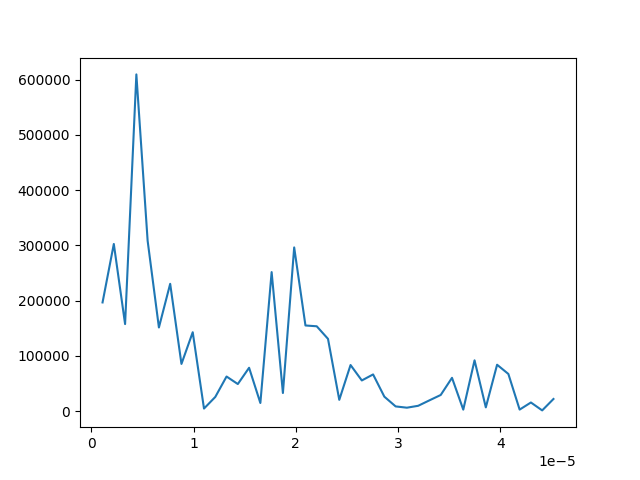

In [164]:
plt.figure()
plt.plot(freqs,power_spectrums[0])

In [148]:
total_user_activity.unstack()

Device_ID                           15     27     29     32     46     47     \
         Datetime                                                              
Activity 2023-04-23 00:00:00+03:00    0.0   12.0    6.0    6.0    6.0   48.0   
         2023-04-23 06:00:00+03:00  184.0   21.0   19.0   18.0   96.0   77.0   
         2023-04-23 12:00:00+03:00  143.0   26.0   12.0   20.0   60.0   58.0   
         2023-04-23 18:00:00+03:00   71.0   37.0   34.0   29.0   63.0   79.0   
         2023-04-24 00:00:00+03:00   37.0   41.0   23.0   18.0   67.0   46.0   
...                                   ...    ...    ...    ...    ...    ...   
         2023-05-12 18:00:00+03:00    0.0   45.0    9.0    8.0   47.0   56.0   
         2023-05-13 00:00:00+03:00    0.0   50.0    4.0    6.0   43.0   51.0   
         2023-05-13 06:00:00+03:00    0.0   48.0    0.0    6.0   42.0   51.0   
         2023-05-13 12:00:00+03:00    0.0   55.0    0.0    4.0   53.0   29.0   
         2023-05-13 18:00:00+03:00    0.0   50.0    0.0    5.0   35.0   18.0   

Device_ID                           65     82     90     95     ...  69909  \
         Datetime                                               ...          
Activity 2023-04-23 00:00:00+03:00   42.0    3.0   46.0    0.0  ...    3.0   
         2023-04-23 06:00:00+03:00   16.0   94.0   75.0   36.0  ...   33.0   
         2023-04-23 12:00:00+03:00    8.0   53.0   61.0   62.0  ...   33.0   
         2023-04-23 18:00:00+03:00   25.0   15.0   66.0   52.0  ...   49.0   
         2023-04-24 00:00:00+03:00   27.0    7.0   51.0  152.0  ...   42.0   
...                                   ...    ...    ...    ...  ...    ...   
         2023-05-12 18:00:00+03:00   77.0   10.0   45.0   29.0  ...   15.0   
         2023-05-13 00:00:00+03:00   92.0   11.0   42.0   11.0  ...   11.0   
         2023-05-13 06:00:00+03:00   20.0    7.0   39.0    0.0  ...    4.0   
         2023-05-13 12:00:00+03:00   15.0    6.0   38.0    0.0  ...    4.0   
         2023-05-13 18:00:00+03:00   13.0    3.0   33.0    1.0  ...    3.0   

Device_ID                           69910  69916  69923  69925  69941  69944  \
         Datetime                                                              
Activity 2023-04-23 00:00:00+03:00    0.0    3.0    0.0    2.0    0.0   29.0   
         2023-04-23 06:00:00+03:00   16.0  102.0   86.0  119.0   86.0   27.0   
         2023-04-23 12:00:00+03:00   51.0  139.0  129.0   90.0   59.0  213.0   
         2023-04-23 18:00:00+03:00   33.0  136.0  100.0   69.0   35.0  205.0   
         2023-04-24 00:00:00+03:00   25.0   42.0   58.0   39.0   25.0  201.0   
...                                   ...    ...    ...    ...    ...    ...   
         2023-05-12 18:00:00+03:00   50.0   25.0    4.0   29.0   57.0   42.0   
         2023-05-13 00:00:00+03:00   99.0   32.0    4.0   39.0   18.0   44.0   
         2023-05-13 06:00:00+03:00   90.0   28.0    0.0   31.0   10.0   43.0   
         2023-05-13 12:00:00+03:00   56.0   36.0    0.0   31.0   22.0   55.0   
         2023-05-13 18:00:00+03:00   28.0   41.0    0.0   30.0    7.0   57.0   

Device_ID                           69952  69967  69992  
         Datetime                                        
Activity 2023-04-23 00:00:00+03:00   27.0    9.0   29.0  
         2023-04-23 06:00:00+03:00  232.0   56.0   46.0  
         2023-04-23 12:00:00+03:00  220.0   67.0   37.0  
         2023-04-23 18:00:00+03:00  148.0   32.0   39.0  
         2023-04-24 00:00:00+03:00   86.0   18.0   33.0  
...                                   ...    ...    ...  
         2023-05-12 18:00:00+03:00  132.0   20.0   41.0  
         2023-05-13 00:00:00+03:00   65.0   13.0   39.0  
         2023-05-13 06:00:00+03:00   22.0   14.0   39.0  
         2023-05-13 12:00:00+03:00  106.0   16.0   41.0  
         2023-05-13 18:00:00+03:00  133.0   15.0   38.0  

[84 rows x 6154 columns]

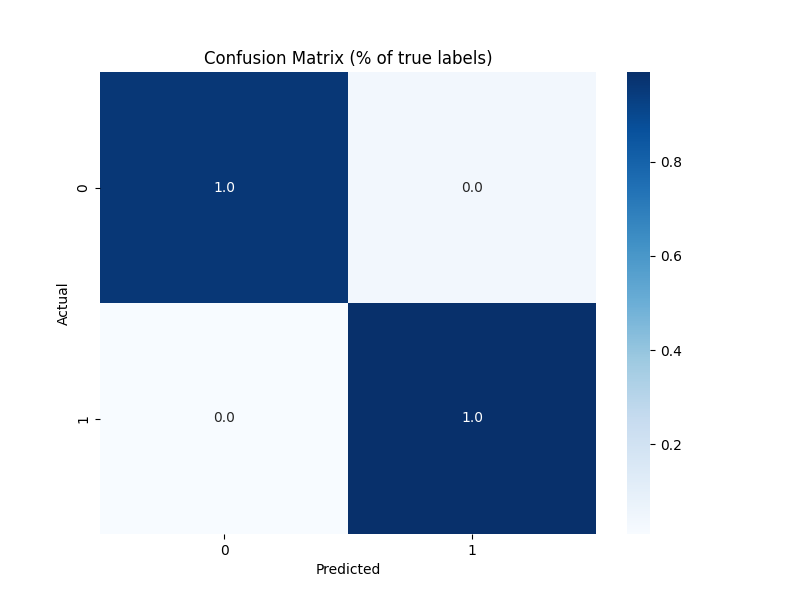

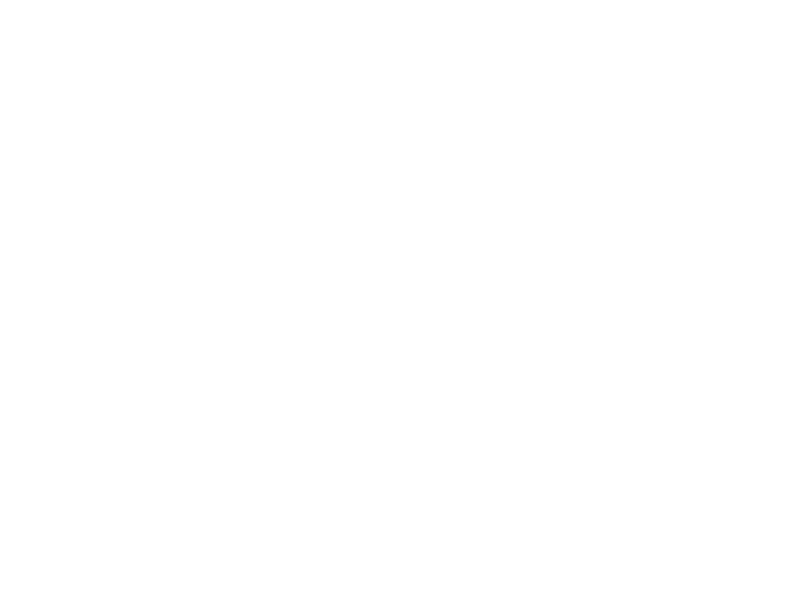

In [178]:
cm = confusion_matrix(y_train, y_train_pred > 0.5,normalize="true")

# create confusion matrix heatmap
plt.figure(figsize=(8,6))
# Create heatmap with percentage values
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix (% of true labels)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [181]:

from sklearn.metrics import accuracy_score


In [182]:
print(accuracy_score(y_test, test_prediction > 0.5))

0.818034118602762


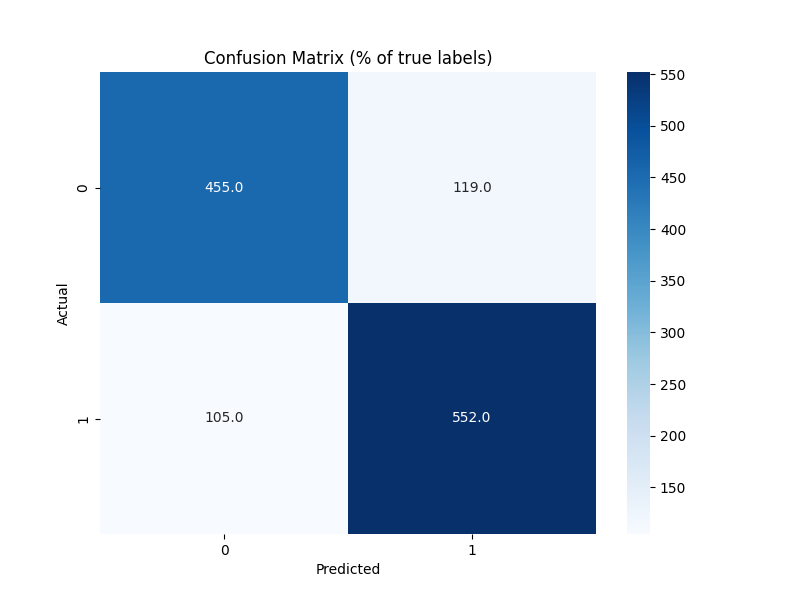

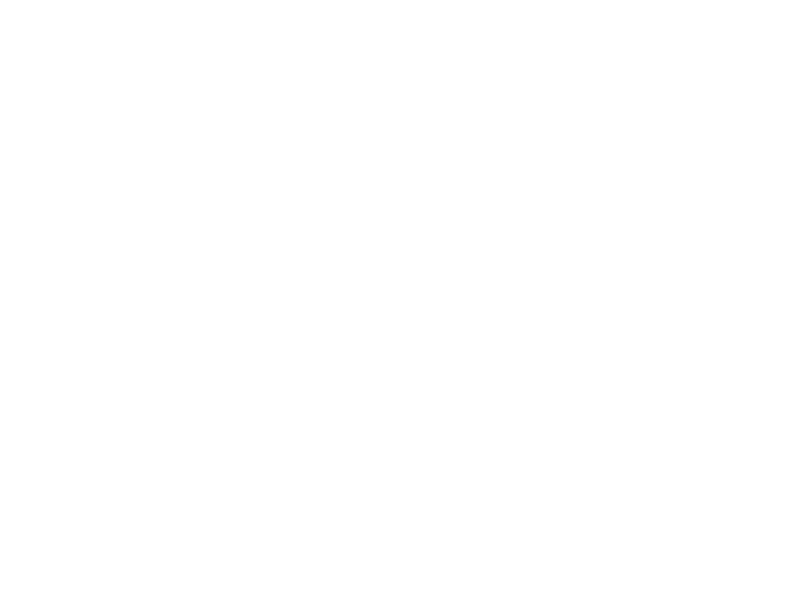

In [179]:
cm = confusion_matrix(y_test, test_prediction > 0.5)

# create confusion matrix heatmap
plt.figure(figsize=(8,6))
# Create heatmap with percentage values
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.1f', cmap='Blues')
plt.title('Confusion Matrix (% of true labels)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
final_x = final_features.drop("Target",axis=1)
final_y = final_features["Target"]
full_data_model, full_data_features = train_model(final_x,final_y,params = params["model"])

In [207]:
import json
with open("submission/best_features.json", "w") as fp:
    json.dump(full_data_features, fp)

In [208]:
import os
os.makedirs("submission",exist_ok=True)
# with open("submission/XGB_model.json", "w") as fp:
full_data_model.estimator_.save_model('submission/XGB_model.json')

In [153]:
import json
with open("submission/best_features.json", "w") as fp:
    json.dump(best_features, fp)

In [86]:
mpd.Series(best_features).to_csv("selected_features.csv",index=False)

In [154]:
import os
os.makedirs("submission",exist_ok=True)
# with open("submission/XGB_model.json", "w") as fp:
selector.estimator_.save_model('submission/XGB_model.json')

In [52]:
domain_activity_timeseries.reset_index()[domain_activity_timeseries.reset_index()["Domain_Name"].isin([int(x) for x in best_features])].set_index(["Datetime","Domain_Name"]).to_parquet("domain_activity_timeseries.parquet")

In [27]:
# manual feature filter
# Create function to filter features based on mean values
# def filter_low_mean_features(features_df, percentile=0.1):
#     # Calculate absolute mean values for each feature
#     abs_means = abs(features_df).mean()
    
#     # Calculate percentile threshold of absolute means
#     threshold = abs_means.quantile(percentile)
    
#     # Get features with absolute means above threshold
#     significant_features = abs_means[abs_means >= threshold].index
    
#     # Filter features

#     return significant_features

# Apply the filtering function


In [200]:
cls = np.array([int(x.replace("cls_","")) for x in best_features if x.startswith("cls_")])
test_df[["Domain_cls1","Domain_cls2","Domain_cls3","Domain_cls4"]]=np.stack([np.random.choice(cls,test_df.shape[0]) for i in range(4)]).T

In [ ]:


import xgboost
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import json
class model:
    def __init__(self,with_neptune=False):
        '''
        Init the model
        '''
        self.model = xgboost.XGBRegressor(
            seed=0, 
            subsample=0.8, 
            colsample_bytree=0.8, 
            learning_rate=0.1,
            n_estimators=150, 
            max_depth=6, 
            objective='binary:logistic',
            eval_metric=roc_auc_score
        )
        self.domain_activity = None
        self.user_activity = None
        self.best_features = None
        self.score_scaler = MinMaxScaler(feature_range=(-1,1))
    def get_cls_proportion(self,df):
        cols=["Domain_cls1","Domain_cls2","Domain_cls3","Domain_cls4"]
        df = df[cols]
        df = df.stack()
        df = df[df!=0]
        df = df.value_counts(normalize=True).T.fillna(0)
        df = df.to_frame().T
        df.columns = [f"cls_{col}" for col in df.columns]
        missing_cols = [x for x in self.best_features if x not in df.columns and x.startswith("cls_")]
        if len(missing_cols)>0:
            df[missing_cols] = np.zeros((df.shape[0], len(missing_cols)))
        return df
    def process_activity_timeseries(self,domain_df,bin_hours=6,gaussian_filter=True,n_days_each_side=3,std=1.5,drop_na=True,drop_zeros=False):
        activity_per_3h = domain_df[["Device_ID"]].resample(f'{str(bin_hours)}h').nunique()
        activity_per_3h.rename(columns={"Device_ID":"Activity"},inplace=True)
        # activity_per_3h = activity_per_3h.to_frame()

        gaussian_window_hours = int(n_days_each_side*24/bin_hours*2) # n_days_each_side * 24h / 3h_per_bin * 2 sides
        if gaussian_filter:
            activity_per_3h = activity_per_3h.rolling(window=gaussian_window_hours, win_type='gaussian',center=True,min_periods=1,closed="both").mean(std=std)
        if drop_na:
            activity_per_3h.dropna(inplace=True)
        if drop_zeros:
            activity_per_3h = activity_per_3h[activity_per_3h["Activity"]!=0]
        return activity_per_3h.round().astype(int)

    def class_probability_score(self,active, p_active_given_a, p_active_given_b, prior_a=0.5, total_users=100):
        """
        Calculate class probability score with vectorized operations
        
        Args:
            active: Boolean indicating if user was active
            p_active_given_a: Probability of activity given class A (0)
            p_active_given_b: Probability of activity given class B (1)
            prior_a: Prior probability for class A
            total_users: Total number of users for confidence calculation
        """
        # Use numpy for vectorized operations
        likelihood_a = np.where(active, p_active_given_a, 1 - p_active_given_a)
        likelihood_b = np.where(active, p_active_given_b, 1 - p_active_given_b)
        
        # Avoid division by zero
        evidence = (likelihood_a * prior_a + likelihood_b * (1 - prior_a))
        posterior_a = (likelihood_a * prior_a) / evidence

        return posterior_a #* confidence_factor


    def get_user_domain_scores(self,user_activity_timeseries,domain_activity_timeseries):
        merged_timeseries_df = domain_activity_timeseries.reset_index().merge(
            user_activity_timeseries.reset_index(), how="inner", on=["Domain_Name", "Datetime"]
        ).set_index(["Datetime", "Domain_Name", "Device_ID"])

        merged_timeseries_df["bin_activity"] = merged_timeseries_df["Activity_0"]+merged_timeseries_df["Activity_1"]
        merged_timeseries_df["total_activity"] = (merged_timeseries_df["target_domain_activity_0"]+merged_timeseries_df["target_domain_activity_1"])
        merged_timeseries_df["relative_0_activity"] = merged_timeseries_df["target_domain_activity_0"]/merged_timeseries_df["total_activity"]
        merged_timeseries_df["score"]=self.class_probability_score(merged_timeseries_df["Activity"], merged_timeseries_df["activity_fraction_0"], merged_timeseries_df["activity_fraction_1"], 
                                                                   prior_a=merged_timeseries_df["relative_0_activity"], total_users=merged_timeseries_df["bin_activity"])
        merged_timeseries_df["relative_bin_activity"] = merged_timeseries_df["bin_activity"]/merged_timeseries_df["total_activity"]
        merged_timeseries_df["weighted_score"] = (merged_timeseries_df["score"])*(merged_timeseries_df["bin_activity"])
        final_scores = merged_timeseries_df.groupby(["Device_ID","Domain_Name"])["weighted_score"].mean()
        final_scores_pivot = final_scores.to_frame().reset_index().pivot(index="Device_ID",columns="Domain_Name").fillna(0)
        final_scores_pivot = final_scores_pivot.droplevel(0, axis=1)
        final_scores_pivot.columns = [str(col) for col in final_scores_pivot.columns]
        missing_columns = [x for x in self.best_domains if x not in final_scores_pivot.columns]
        final_scores_pivot[missing_columns] = np.zeros((final_scores_pivot.shape[0], len(missing_columns)))
        final_scores_pivot = final_scores_pivot[self.best_domains]
        return final_scores_pivot
    def load_minmax_scaler(self,scaler_path):
        '''
        Load the MinMaxScaler from the given path
        '''
        with open(scaler_path, 'r') as f:
            loaded_params = json.load(f)
        self.score_scaler.min_ = np.array([loaded_params["min_"]], dtype=np.float64)
        self.score_scaler.scale_ = np.array([loaded_params["scale_"]], dtype=np.float64)
        self.score_scaler.data_min_ = np.array([loaded_params["data_min_"]], dtype=np.float64)
        self.score_scaler.data_max_ = np.array([loaded_params["data_max_"]], dtype=np.float64)
        self.score_scaler.data_range_ = np.array([loaded_params["data_range_"]], dtype=np.float64)
        self.score_scaler.feature_range = tuple(loaded_params["feature_range"])
    def load(self, dir_path):
        '''
        Load the trained model and domain activity data
        '''
        import os
        import json

        model_path = os.path.join(dir_path, 'XGB_model.json')
        self.model.load_model(model_path)
        best_features_path = os.path.join(dir_path, 'best_features.json')
        with open(best_features_path, "r") as fp:
            self.best_features = json.load(fp)
        self.best_domains = [x for x in self.best_features if x.isnumeric()]
        domain_activity_path = os.path.join(dir_path, 'best_domain_activity.parquet')
        self.domain_activity = pd.read_parquet(domain_activity_path)
        self.load_minmax_scaler(os.path.join(dir_path,'minmax_scaler.json'))
    def predict(self, X):
        '''
        Predict the class probability for the input data
        '''
        # Process user timeseries
        X = X.copy()
        
        if X['Datetime'].dtype == 'O':
            X['Datetime'] = pd.to_datetime(X['Datetime'])
        if "Device_ID" not in X.columns:
            X["Device_ID"] = 1
        X.set_index(['Datetime'], inplace=True)
        x_domains = X[X['Domain_Name'].isin([int(x) for x in self.best_domains])]
        user_timeseries = x_domains[['Device_ID', 'Domain_Name']].groupby(["Device_ID","Domain_Name"]).apply(lambda x :self.process_activity_timeseries(
            x,
            bin_hours=6,
            gaussian_filter=True,
            n_days_each_side=3,
            std=1.5,
            drop_na=True,
            drop_zeros=False
        ))
        
        # Get domain scores
        final_scores = self.get_user_domain_scores(user_timeseries, self.domain_activity)
        final_scores.iloc[:] = self.score_scaler.transform(final_scores.values.reshape(-1,1)).reshape(final_scores.shape)
        cls_proportion = self.get_cls_proportion(X)
        final_features = pd.concat([final_scores.reset_index(),cls_proportion.reset_index()],axis=1)[self.best_features]
        # Make prediction
        prediction = self.model.predict(final_features)
        return prediction[0]

In [45]:
test_df = db_df[db_df["Device_ID"].isin(test_device_ids)].reset_index()

In [ ]:
%load_ext autoreload
%autoreload 2

In [47]:
sys.path.append("/home/tom.touati/mafat-challenge/code/submission/model.py")

In [ ]:
import pandas as pd
import warnings

# Suppress all warnings
warnings.simplefilter("ignore")
import sys
import os
# X = test_df[test_df["Device_ID"].isin(list(set(test_df["Device_ID"])))]._to_pandas()#pd.read_csv('test_sample.csv')

from code.submission.model import model
import sys
import os
X=pd.read_csv('test_sample.csv')
M = model()
M.load('submission')
Y_test=[]
y_real=[]
@ray.remote
def ray_predict(m,x):
    return m.predict(x)
unique_Device_IDs = list(set(X.Device_ID))
id_encountered = False
for id in unique_Device_IDs:
    X_test = X.loc[X['Device_ID'] == id]
    # print("running device_id {}...".format(id))
    X_test.drop('Device_ID', axis=1, inplace=True)
    print(M.predict(X_test))
    # Y_test.append(ray_predict.remote(M,X_test))
    # y_real.append(X_test['Target'].iloc[0])
    # print(Y_test[-1], y_real)

# print(f'Prediction: {Y_test[0]}')
Y_test = [ray.get(y) for y in Y_test]


In [ ]:
from sklearn.metrics import roc_auc_score

# Convert lists to numpy arrays if needed
roc_auc = roc_auc_score(y_real, Y_test)
print(f'ROC AUC Score: {roc_auc:.3f}')